In [1]:
# import localcider
# from localcider.sequenceParameters import SequenceParameters
# import protfasta
# import glob, 
import pandas as pd
import numpy as np
import re
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict 
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

import ete3
from ete3 import TreeStyle, PhyloTree, Tree, faces, NodeStyle, AttrFace, TextFace
from ete3.treeview.faces import add_face_to_node

import seaborn as sns
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
# import editdistance

from tqdm import tqdm

# import YeastAnalysisfunctions as YAF

import random
random.seed(25)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42


In [2]:
import matplotlib
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

In [3]:
seq_data = pd.read_pickle('../data/FullOrthologDF_20240930')
seq_data = seq_data.rename(columns={"SpeciesName" : "name"})

In [4]:
# Read in species name data
species_mapping = pd.read_csv("../data/phylogenetic_info/top138_phyloinfo.csv")
merged_data = species_mapping.merge(seq_data, on="name")

# Longest first
merged_data = merged_data.sort_values("Length", ascending=False)

# Removing the really long seqs
merged_data = merged_data[merged_data['Length'] < 1100]

In [5]:
# Finds the start of the WxxLF motif, which the sequences are aligned on
def find_WLF(s):
    p = re.compile("W..LF")
    for m in p.finditer(s):
        return m.start()
    return -1

In [6]:
# Get location of all WxxLF motifs
merged_data.loc[:, "Location_WxxLF"] = merged_data["Seq"].apply(find_WLF)

# Getting the WxxLF motif that is the furthest into a sequence, all other sequence will be aligned to this
align_to = max(merged_data["Location_WxxLF"])
align_to

970

In [7]:
# Calculate padding i.e. how much "sequence" needs to be added to the front to align all the WxxLF motifs
merged_data.loc[:,"pad_by"] = list(merged_data["Location_WxxLF"] * -1 + align_to)
merged_data

,id,name,TreeLeaf,Validated,SpeciesName,NCBI Taxon,Note,AD_seq,full_sequence,Seq,Length,WxxLF_loc,SmoothedActivites,LinearCharge,LinearHydrophobicityKD,SmoothedActivitesLoess,Location_WxxLF,pad_by
384,NaN,Sordariomycetes_jgi|Daces1|522128|fgenesh1_pg....,Daces1,Yes,Dactylonectria estremocensis,NaN,NaN,NaN,NaN,MILSLTLCLTFFGLTFVIAAPEDAETLANLEVYTSLRRCAKDCFWG...,1098,970,"[58986.997709680654, 58986.997709680654, 58986...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.7933333333333333, 0.7355555555555...","[57528.193069651315, 57528.193069651315, 57528...",970,0
387,NaN,Sordariomycetes_jgi|Daces1|604900|estExt_fgene...,Daces1,Yes,Dactylonectria estremocensis,NaN,NaN,NaN,NaN,MILSLTLCLTFFGLTFVIAAPEDAETLANLEVYTSLRRCAKDCFWG...,1080,952,"[58986.997709680654, 58986.997709680654, 58986...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.7933333333333333, 0.7355555555555...","[57528.193069651315, 57528.193069651315, 57528...",952,18
194,NaN,Sordariomycetes_jgi|OphPMI507_1|434063|gm1.8796_g,OphPMI507_1,Yes,Ophiostoma sp. PMI507,NaN,NaN,NaN,NaN,MSSFFSLGRHKDSSPSAPQPSLQFQTQTQLPSPPQSQNNNTQFNAG...,1066,935,"[24009.756126420354, 24009.756126420354, 24009...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.4, ...","[0.0, 0.0, 0.6311111111111112, 0.5711111111111...","[29402.439599689482, 29402.439599689482, 29402...",935,35
298,NaN,Sordariomycetes_jgi|Lasov1|716087|estExt_Genem...,Lasov1,Yes,Lasiosphaeria ovina,NaN,NaN,NaN,NaN,MKRLFCWPFTDGDHDDHGSTSQPGSGSGTPQRKGSVASTGQPDNIR...,1064,937,"[33231.09263527936, 33231.09263527936, 33231.0...","[0.0, 0.0, 0.4, 0.4, 0.2, 0.0, 0.0, 0.0, -0.2,...","[0.0, 0.0, 0.5022222222222222, 0.5155555555555...","[19712.177339465088, 19712.177339465088, 19712...",937,33
294,120.0,Sordariomycetes_jgi|Lasov1|674147|gm1.2096_g,Lasov1,Yes,Lasiosphaeria ovina,92902.0,NaN,QEPFMSAPNSTALTALTSPSLYDESPDFGSGFDVSPNFAGSDFDAG...,MTGSGDHDDHGSTSQPGSGSGTPQRKGSVASTGQPDNIRHYHHVPT...,MTGSGDHDDHGSTSQPGSGSGTPQRKGSVASTGQPDNIRHYHHVPT...,1010,883,"[14540.100542343382, 14540.100542343382, 14540...","[0.0, 0.0, 0.0, -0.2, -0.2, -0.4, -0.6, -0.6, ...","[0.0, 0.0, 0.49111111111111116, 0.371111111111...","[15873.98354908541, 15873.98354908541, 15873.9...",883,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,21.0,Dothideomycetes_jgi|Didsa1|381788|estExt_Genew...,Didsa1,Yes,Didymocrea sadasivanii,372059.0,Splicing isoform / truncation (?) of other Did...,MFQGDSCFPTGTDTWYSLFPEEESRTVMPAVTTP,MFQGDSCFPTGTDTWYSLFPEEESRTVMPAVTTPLAAPALERTVSS...,MFQGDSCFPTGTDTWYSLFPEEESRTVMPAVTTPLAAPALERTVSS...,157,14,"[190922.41852774887, 161032.45391660908, 15386...","[0.0, 0.0, -0.2, -0.2, -0.2, -0.2, -0.2, 0.0, ...","[0.0, 0.0, 0.43999999999999995, 0.38, 0.373333...","[170312.56492479687, 170312.56492479687, 17031...",14,956
181,43.0,Eurotiomycetes_jgi|Penatra1|34162|e_gw1.2.1160.1,Penatra1,Yes,Penicillium atramentosum,36652.0,NaN,MFTDLDVAGHEDWPSLFDHSSEPLNAFDLATL,MFTDLDVAGHEDWPSLFDHSSEPLNAFDLATLDAAAAYSVEPKKPI...,MFTDLDVAGHEDWPSLFDHSSEPLNAFDLATLDAAAAYSVEPKKPI...,157,12,"[261940.99846290916, 261910.30458108656, 26191...","[0.0, 0.0, -0.2, -0.4, -0.4, -0.4, -0.2, -0.2,...","[0.0, 0.0, 0.5955555555555556, 0.4755555555555...","[262143.0, 262143.0, 262143.0, 262143.0, 26214...",12,958
180,42.0,Eurotiomycetes_jgi|Penatra1|32388|gw1.2.1490.1,Penatra1,Yes,Penicillium atramentosum,36652.0,NaN,SPMFTDLDVAGHEDWPSLFDHSSEPLNAFDLATL,SPMFTDLDVAGHEDWPSLFDHSSEPLNAFDLATLDAAAAYSVEPKK...,SPMFTDLDVAGHEDWPSLFDHSSEPLNAFDLATLDAAAAYSVEPKK...,154,14,"[173113.6358480084, 215442.77937959705, 230942...","[0.0, 0.0, 0.0, -0.2, -0.2, -0.4, -0.4, -0.4, ...","[0.0, 0.0, 0.5355555555555556, 0.4755555555555...","[238988.135652909, 238988.135652909, 238988.13...",14,956
201,64.0,Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#...,Oidma1,Yes,Oidiodendron maius,913774.0,NaN,MDHSLAGDPWYPLFPPEDQFEVPKIEDSS,MDHSLAGDPWYPLFPPEDQFEVPKIEDSSPLLPEEELEVSEALRTS...,MDHSLAGDPWYPLFPPEDQFEVPKIEDSSPLLPEEELEVSEALRTS...,142,9,"[142319.55237852785, 98529.82136074522, 8

# Drawing from set of activities

In [8]:
# CONTROL: Make sure we aren't chaing our original activities
# Make a shuffled list of all activities
flattened_activities = [i for ls in merged_data['SmoothedActivitesLoess'].values for i in ls]

# Assign to each sequence based on sequence length
lengths = [len(ls) for ls in merged_data['SmoothedActivitesLoess'].values]

# Calculate sum per sequence
i = 0
sums_orig = []
for l in lengths:
    reconstructed_acts = flattened_activities[i:l+i]
    i += l
    sums_orig.append(sum(reconstructed_acts))

In [13]:
merged_data['integrals'] = sums_orig
merged_data[['name', 'SpeciesName', 'Seq', 'integrals']].to_csv("../data/activity_integrals.csv")

In [13]:
# Make a shuffled list of all activities
# Sampling without replacement
flattened_activities = [i for ls in merged_data['SmoothedActivitesLoess'].values for i in ls]

shuffled_vars = []
shuffled_means = []

for i in tqdm(range(1000)):
    random.shuffle(flattened_activities)

    # Assign to each sequence based on sequence length
    lengths = [len(ls) for ls in merged_data['SmoothedActivitesLoess'].values]

    # Calculate sum per sequence
    i = 0
    sums = []
    for l in lengths:
        reconstructed_acts = flattened_activities[i:l+i]
        i += l
        sums.append(sum(reconstructed_acts))

    shuffled_vars.append(np.var(sums))
    shuffled_means.append(np.mean(sums))

100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]


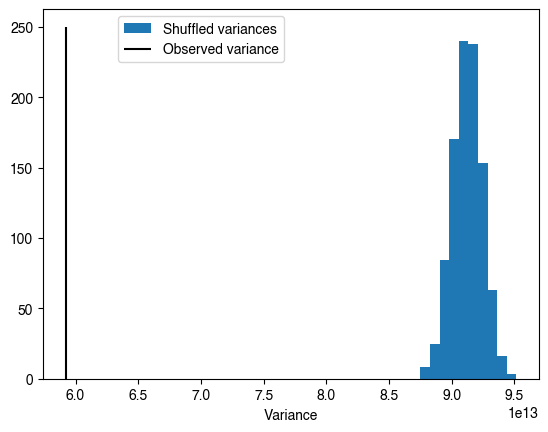

In [337]:
plt.hist(shuffled_vars, label="Shuffled variances")
plt.vlines(np.var(sums_orig), 0, 250, color='black', label="Observed variance")
plt.xlabel("Variance")
plt.legend(bbox_to_anchor=(0.5, 1))

In [340]:
np.var(sums_orig)
np.var(sums)

np.float64(91617528600716.98)

Text(0.5, 0, 'Integral of smoothed activity')

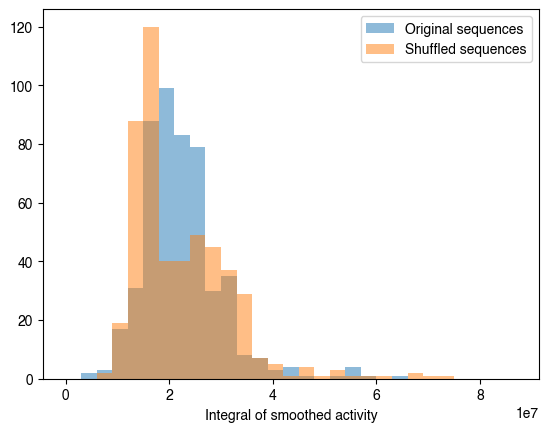

In [338]:
bins = np.arange(0, 90000000, step = 3000000)

plt.hist(sums_orig, alpha=0.5, bins=bins, label="Original sequences")
plt.hist(sums, bins=bins, label="Shuffled sequences", alpha=0.5)


plt.legend()
plt.xlabel("Integral of smoothed activity")

# Sampling with replacement

In [14]:
# Make a shuffled list of all activities
# Sampling without replacement
flattened_activities = [i for ls in merged_data['SmoothedActivitesLoess'].values for i in ls]

shuffled_vars_replacement = []
shuffled_means_replacement = []

for i in tqdm(range(1000)):

    # Assign to each sequence based on sequence length
    lengths = [len(ls) for ls in merged_data['SmoothedActivitesLoess'].values]

    # Calculate sum per sequence
    i = 0
    sums = []
    for l in lengths:
        reconstructed_acts = random.choices(flattened_activities, k=l)
        sums.append(sum(reconstructed_acts))

    shuffled_vars_replacement.append(np.var(sums))
    shuffled_means_replacement.append(np.mean(sums))

100%|██████████| 1000/1000 [00:13<00:00, 74.94it/s]


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


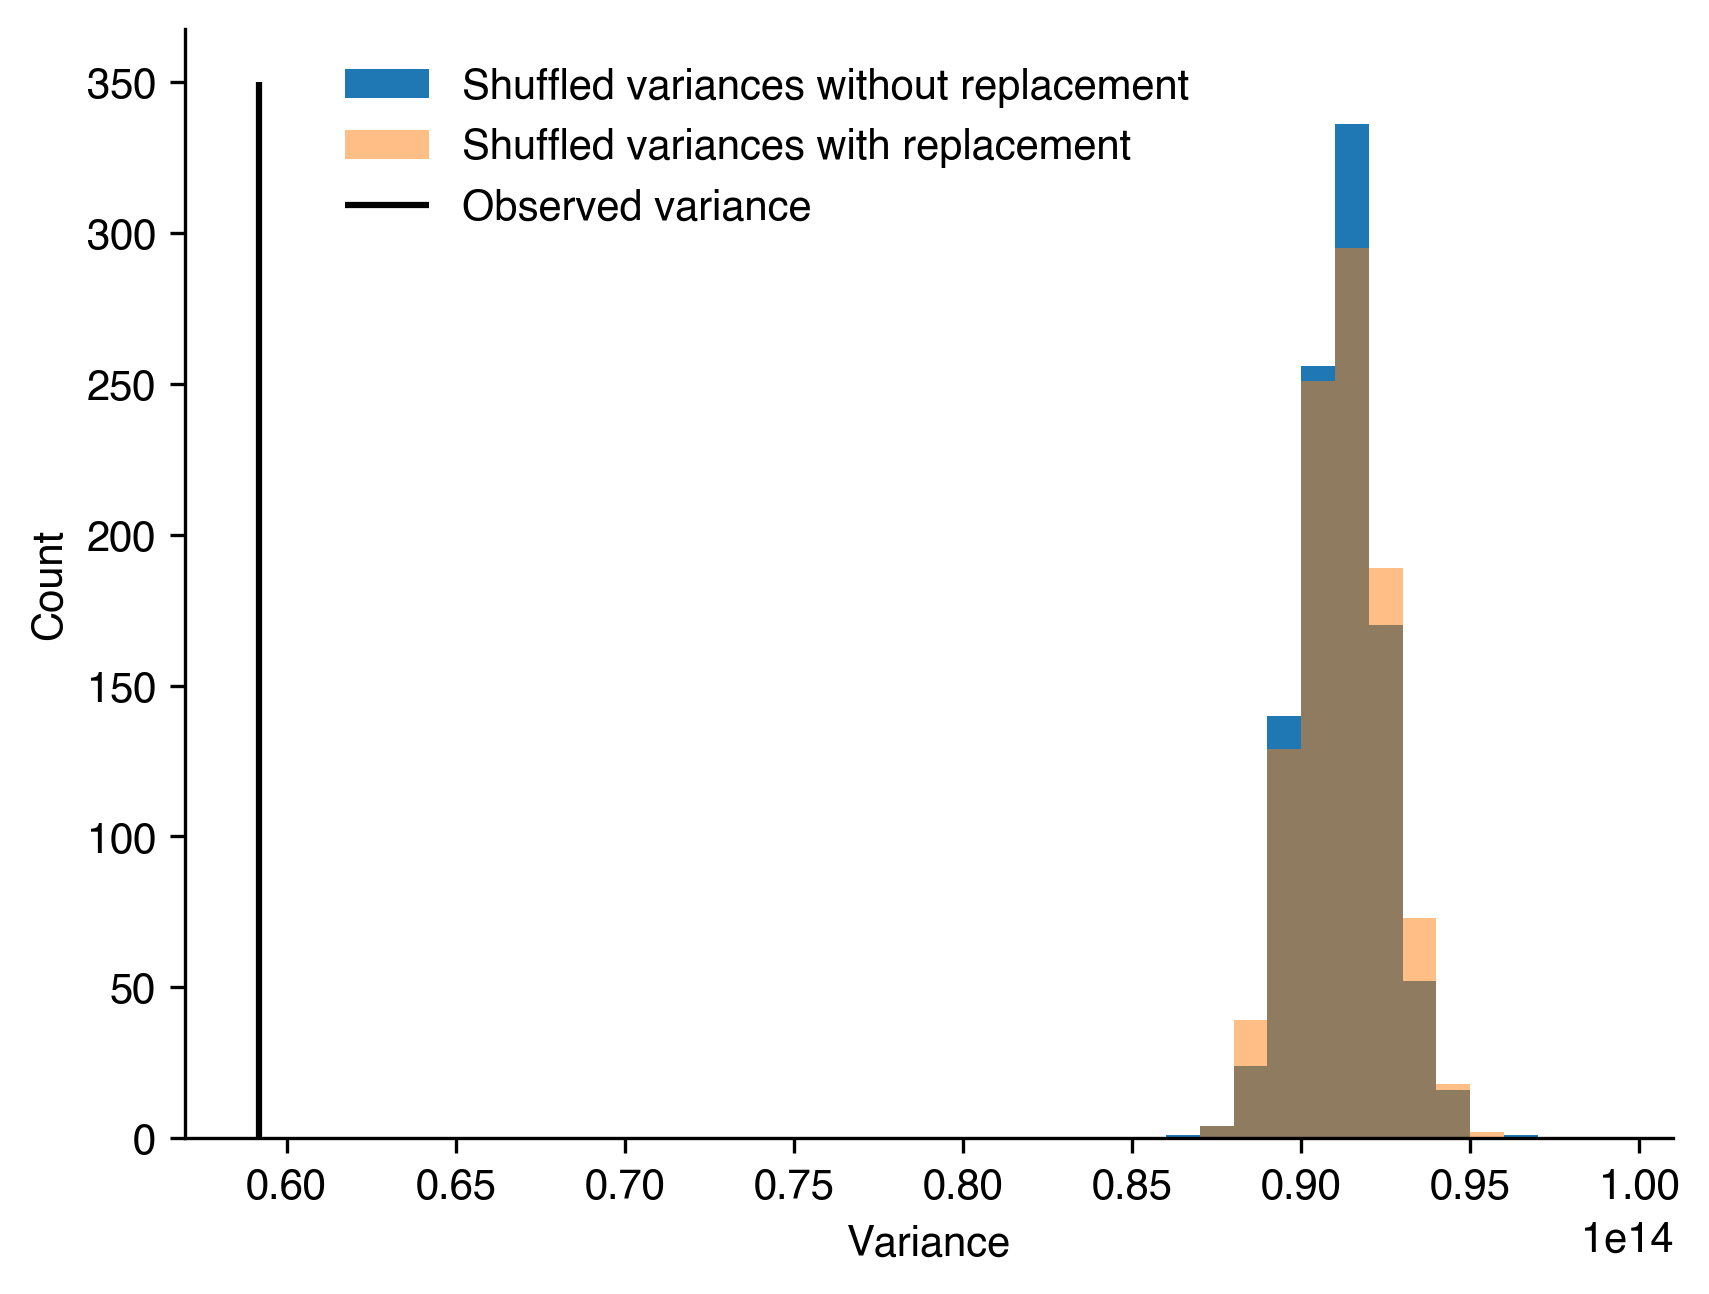

In [36]:
bins = np.arange(5.9e13, 10e13, 1e12)
plt.hist(shuffled_vars, label="Shuffled variances without replacement", bins=bins)
plt.hist(shuffled_vars_replacement, label="Shuffled variances with replacement", alpha=0.5, bins=bins)

plt.vlines(np.var(sums_orig), 0, 350, color='black', label="Observed variance")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(0.7, 1), frameon=False)
sns.despine()
plt.savefig("../figures/integrals_shuffles_vairance.pdf")

# Shuffling each column

In [98]:
def make_activity_matrix(data, duplicates=True, leaf_names = 'TreeLeaf'):
    """
    Used in method activity_heatmap_on_tree
    Creates a pandas dataframe of the activites where now each position
    in the sequence occupies its own cell. Entries are padded with -1
    Also merges species with multiple genes (so there is one row per specie)

    Returns 
    -------
    pd.DataFrame
        The reformatted pandas dataframe, as described above

    """ 
         

    if duplicates: 
        used_names = []
        padded_dict = {}   
        # For each column
        while len(used_names) < len(merged_data):
            current_data = merged_data[[n not in used_names for n in merged_data['name']]].sort_values("Length", ascending=True).drop_duplicates(leaf_names, keep='first').reset_index()
            end_align = max(current_data["Length"] + current_data["pad_by"])

            for row_index in current_data.index:
                sub_list = current_data.loc[row_index, 'SmoothedActivitesLoess']
                new_list = [0] * current_data.loc[row_index, 'pad_by'] + list(sub_list) + [0] * (end_align - current_data.loc[row_index, 'pad_by'] - len(sub_list) + 50)
                # print(align_to)
                curr_name = current_data.loc[row_index, leaf_names]
                if curr_name in padded_dict.keys():
                    padded_dict[curr_name] = padded_dict[curr_name] + new_list
                else:
                    padded_dict[curr_name] = new_list
                used_names.append(current_data.loc[row_index, "name"])

        activity_position_matrix = pd.DataFrame(padded_dict.values())
        activity_position_matrix.index = padded_dict.keys()
        activity_position_matrix = activity_position_matrix.fillna(0)

    else:
        positional_activity_df_padded = []
        names = []
        for group_name, df_group in data.groupby(leaf_names):
            new_list = []
            df_group = df_group.sort_values("Length", ascending=False).reset_index()

            sub_list = df_group.loc[0, 'SmoothedActivitesLoess']

            # new_list = [-1] * df_group.loc[0, 'pad_by'] + list(sub_list) 
            new_list = [0] * df_group.loc[0, 'pad_by'] + list(sub_list) 

            positional_activity_df_padded.append(new_list)
            names.append(group_name)

        activity_position_matrix = pd.DataFrame(positional_activity_df_padded)
        activity_position_matrix.index = names
        activity_position_matrix = activity_position_matrix.fillna(0)

    return activity_position_matrix

In [99]:
activity_position_matrix = make_activity_matrix(merged_data, leaf_names="name")
activity_position_matrix

,0,1,2,3,4,5,6,7,8,9,...,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379
Pezizomycetes_jgi|Morco1|243381|CE243380_84307,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#_311_#_isotig02349,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Eurotiomycetes_jgi|Penatra1|32388|gw1.2.1490.1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Eurotiomycetes_jgi|Penatra1|34162|e_gw1.2.1160.1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Dothideomycetes_jgi|Didsa1|381788|estExt_Genewise1.C_210065,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sordariomycetes_jgi|Lasov1|674147|gm1.2096_g,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Sordariomycetes_jgi|Lasov1|716087|estExt_Genemark1.C_1_t50096,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Sordariomycetes_jgi|OphPMI507_1|434063|gm1.8796_g,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0
Sordariomycetes_jgi|Daces1|604900|estExt_fgenesh1_pg.C_5_t10114,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0


In [209]:
shuffled_df_rows

,0,1,2,3,4,5,6,7,8,9,...,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379
0,0.000000,0.000000,86876.863727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,54237.475155,0.000000,32483.185740,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20532.769538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44771.918603
2,0.000000,35373.388178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31088.382936
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14170.159391
4,16691.841311,0.000000,0.000000,0.000000,0.000000,23098.029854,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,0.000000,16906.085382,52058.634772,30890.650204,27263.135680,77907.488907,62273.689852,0.000000,45251.420758,65912.197861,...,0.000000,0.000000,37296.713365,63661.156837,36062.652351,38944.301016,0.000000,24033.632538,67620.072397,19269.858295
493,58535.989145,0.000000,46422.860659,55265.524856,123051.277191,37718.296581,0.000000,27958.462031,17839.730476,0.000000,...,0.000000,19100.656819,38364.832982,36261.710214,57898.958705,38311.113029,0.000000,61383.623954,0.000000,0.000000
494,44121.305247,52364.774041,0.000000,0.000000,0.000000,58422.888770,0.000000,32853.225611,41207.344369,0.000000,...,48938.440506,42202.600330,96185.983715,104433.601204,0.000000,97647.450096,33542.807612,0.000000,51154.157721,37254.285944
495,0.000000,38190.264121,0.000000,24833.150117,15286.474319,0.000000,17263.687221,34380.877509,27392.225521,0.000000,...,0.000000,29886.035662,67673.085600,67589.312756,24188.646509,74096.652234,41905.101594,26575.973269,68952.757046,30977.418657


(array([ 0.,  2.,  3., 17., 31., 88., 99., 83., 79., 30., 35.,  8.,  7.,
         3.,  4.,  1.,  0.,  1.,  4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([       0.,  3000000.,  6000000.,  9000000., 12000000., 15000000.,
        18000000., 21000000., 24000000., 27000000., 30000000., 33000000.,
        36000000., 39000000., 42000000., 45000000., 48000000., 51000000.,
        54000000., 57000000., 60000000., 63000000., 66000000., 69000000.,
        72000000., 75000000., 78000000., 81000000., 84000000., 87000000.]),
 <BarContainer object of 29 artists>)

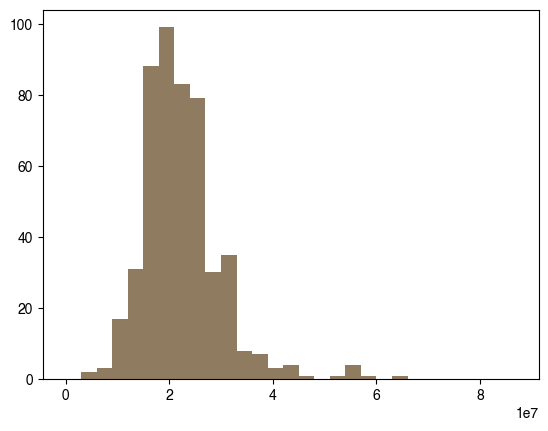

In [210]:
# These should be the same
shuffled_df_rows = pd.DataFrame([random.sample(list(activity_position_matrix.loc[i].values), len(activity_position_matrix.columns)) for i in activity_position_matrix.index])
row_sums = shuffled_df_rows.sum(axis=1)
plt.hist(row_sums, bins=bins)
plt.hist(orig_col_sums, alpha=0.5, bins=bins)

In [165]:
actual_var

np.float64(59193933451480.73)

In [ ]:
# Observed variance is greater? 
6.96675814e+11 / 59193933451480.73

0.011769378606526321

In [227]:
actual_row_sums = activity_position_matrix.sum(axis=1)
actual_col_sums = activity_position_matrix.sum(axis=0)
actual_row_sums

Pezizomycetes_jgi|Morco1|243381|CE243380_84307                      1.148185e+07
Leotiomycetes_jgi|Oidma1|18868|fgenesh1_kg.6_#_311_#_isotig02349    4.650762e+06
Eurotiomycetes_jgi|Penatra1|32388|gw1.2.1490.1                      1.167395e+07
Eurotiomycetes_jgi|Penatra1|34162|e_gw1.2.1160.1                    1.137546e+07
Dothideomycetes_jgi|Didsa1|381788|estExt_Genewise1.C_210065         8.499624e+06
                                                                        ...     
Sordariomycetes_jgi|Lasov1|674147|gm1.2096_g                        5.646006e+07
Sordariomycetes_jgi|Lasov1|716087|estExt_Genemark1.C_1_t50096       5.961266e+07
Sordariomycetes_jgi|OphPMI507_1|434063|gm1.8796_g                   6.323030e+07
Sordariomycetes_jgi|Daces1|604900|estExt_fgenesh1_pg.C_5_t10114     5.369443e+07
Sordariomycetes_jgi|Daces1|522128|fgenesh1_pg.5_#_116               5.414988e+07
Length: 497, dtype: float64

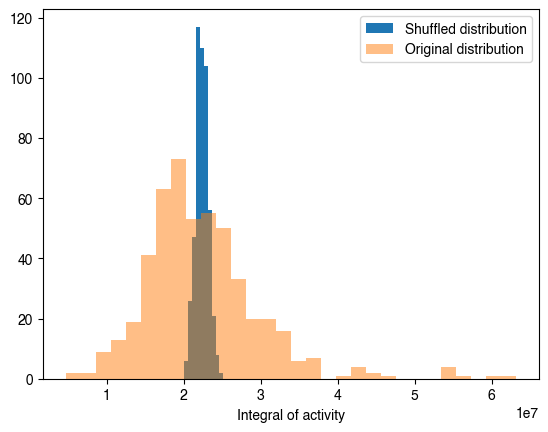

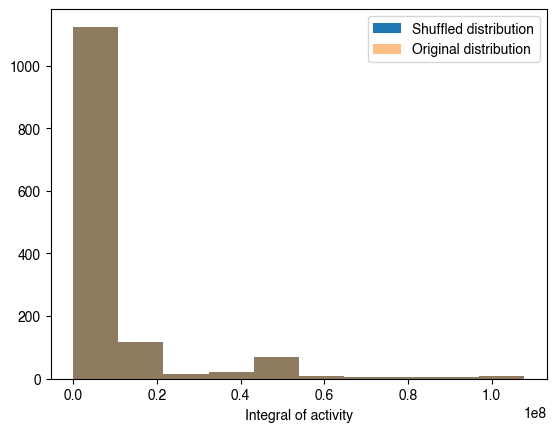

11129360960.917084
11129360960.917084


In [231]:
shuffled_df = pd.DataFrame([random.sample(list(activity_position_matrix[i].values), len(activity_position_matrix.index)) for i in activity_position_matrix.columns]).T
row_sums = shuffled_df.sum(axis=1)
col_sums = shuffled_df.sum(axis=0)

plt.hist(row_sums, bins=10, label="Shuffled distribution")
plt.hist(actual_row_sums, alpha=0.5, bins=30, label="Original distribution")
plt.xlabel("Integral of activity")
plt.legend()
plt.show()

plt.hist(col_sums, bins=10, label="Shuffled distribution")
plt.hist(actual_col_sums, alpha=0.5, bins=10, label="Original distribution")
plt.xlabel("Integral of activity")
plt.legend()
plt.show()

print(row_sums.sum())
print(actual_row_sums.sum())

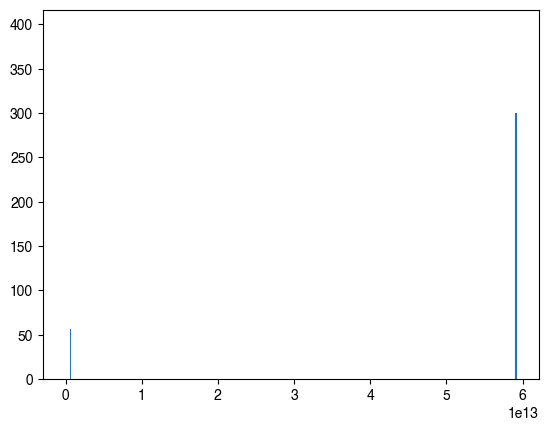

In [ ]:
bins = np.arange(0, 90000000, step = 3000000)

means = np.zeros(len(activity_position_matrix.index))
vars = np.zeros(len(activity_position_matrix.index))
for j in tqdm(range(100)):
    shuffled_df = pd.DataFrame([random.sample(list(activity_position_matrix[i].values), len(activity_position_matrix.index)) for i in activity_position_matrix.columns]).T
    row_sums = shuffled_df.sum(axis=1)
    means[j] = (np.mean(row_sums)) # Will always be the same
    vars[j] = (np.var(row_sums))


plt.hist(row_sums, bins=bins)
plt.hist(orig_col_sums, alpha=0.5, bins=bins)

# Actual var
actual_row_sums = activity_position_matrix.sum(axis=1)
actual_var = np.var(actual_row_sums)

plt.hist(vars)
plt.vlines(actual_var, 0, 300)

In [ ]:
# actual values


np.float64(59193933451480.73)

In [ ]:
plt.hist(vars)
plt.vlines()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


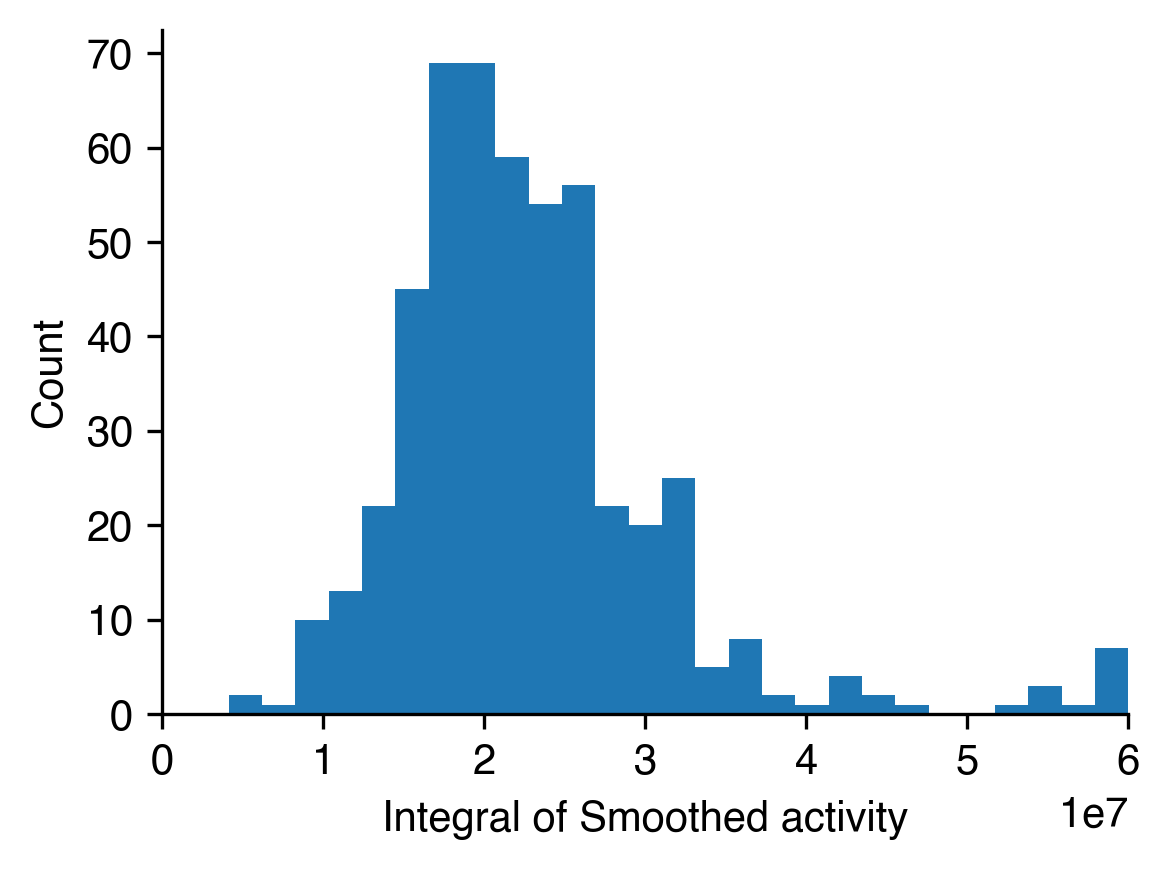

In [38]:
# Max's code
FullOrthoDF = pd.read_pickle('../data/FullOrthologDF_20240930')

# Integral of smoothed activity
plt.figure(figsize=(4,3))
tempIntegrals =[]

for i, row in FullOrthoDF.iterrows():
    integral = np.sum(row.SmoothedActivitesLoess)
    tempIntegrals.append(integral)

FullOrthoDF['ActivitySum'] = tempIntegrals

bins = np.linspace(0, 6e7,30)
bins[-1]=1.6e8
plt.hist(FullOrthoDF.ActivitySum,bins)
plt.xlabel('Integral of Smoothed activity')
plt.xlim(0,6e7)
plt.ylabel('Count')
plt.tight_layout()
sns.despine()
# plt.show()

plt.savefig("../figures/integrals_distribution.pdf")